In [49]:
# Import required libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import scipy

PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))

# Configure visualization
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


# Data Loading and Initial Inspection

This section loads the original segment and node panels (rich version: accidents with their type by segment/node-year-month). The trimmed panel contains only columns that are present in the node panel (acc_* columns).

In [50]:
# Load aggregated risk panels
segment_panel = gpd.read_parquet("../data/merged/berlin_bike_accident_strava_panel.parquet")
segment_panel = segment_panel.rename(columns={"sum_strava_total_trip_count": "monthly_strava_trips"})
segment_panel = segment_panel[segment_panel['monthly_strava_trips'] > 0]

node_panel = pd.read_parquet("../data/merged/berlin_bike_accident_node_panel.parquet")
node_panel = node_panel[node_panel['monthly_strava_trips'] > 0]

# Print original segment_panel info
print("=== Original Segment Panel ===")
print(f"Shape: {segment_panel.shape}")
print(f"Columns: {segment_panel.columns.tolist()}")

# Remove risk columns from node_panel
risk_cols_to_drop = ['risk_accidents_per_trip', 'risk_accidents_per_10k_trips']
node_panel = node_panel.drop(columns=[col for col in risk_cols_to_drop if col in node_panel.columns])

print("\n=== Node Panel ===")
print(f"Shape: {node_panel.shape}")
print(f"Columns: {node_panel.columns.tolist()}")

# Keep only columns in segment_panel that exist in node_panel
common_cols = [col for col in node_panel.columns if col in segment_panel.columns]
segment_panel_trimmed = segment_panel[['counter_name'] +  common_cols]

print("\n=== Trimmed Segment Panel (aligned to node columns) ===")
print(f"Shape: {segment_panel_trimmed.shape}")
print(f"Columns: {segment_panel_trimmed.columns.tolist()}")

=== Original Segment Panel ===
Shape: (242847, 204)
Columns: ['counter_name', 'year', 'month', 'sum_count', 'monthly_strava_trips', 'sum_strava_ride_count', 'sum_strava_ebike_ride_count', 'sum_strava_total_people_count', 'sum_strava_total_commute_trip_count', 'sum_strava_total_leisure_trip_count', 'sum_strava_total_morning_trip_count', 'sum_strava_total_midday_trip_count', 'sum_strava_total_evening_trip_count', 'sum_strava_total_overnight_trip_count', 'sum_strava_total_male_people_count', 'sum_strava_total_female_people_count', 'sum_strava_total_18_34_people_count', 'sum_strava_total_35_54_people_count', 'sum_strava_total_55_64_people_count', 'sum_strava_total_65_plus_people_count', 'sum_strava_total_unspecified_people_count', 'sum_motorized_vehicle_count_all_vehicles_6km', 'sum_motorized_vehicle_count_cars_6km', 'sum_motorized_vehicle_count_trucks_6km', 'sum_motorized_vehicle_count_all_vehicles', 'sum_motorized_vehicle_count_cars', 'sum_motorized_vehicle_count_trucks', 'mean_strava_to

### Merged dataset of segments and nodes in combined_panel to analyse acc_* features (types) influence in both types

We will analyse:
1. light_condition (daylight, darkness, ...)
2. weekday_type (weekday or weekend)
3. time_of_day (work hours, night, evening)
4. season (winter, summer, ...)

In [51]:
# Prepare segment and node panels for union
# segment_panel_trimmed: trimmed segment panel
segment_prep = segment_panel_trimmed.copy()
segment_prep['is_node'] = 0
segment_prep = segment_prep.rename(columns={'counter_name': 'id'})

node_prep = node_panel.copy()
node_prep['is_node'] = 1
node_prep = node_prep.rename(columns={'node_id': 'id'})

# Union both panels for further analysis
combined_panel = pd.concat([segment_prep, node_prep], ignore_index=True)

# Remove all columns with acc_injury_severity.., acc_accident_kind, acc_accident_type
cols_to_remove = [col for col in combined_panel.columns if col.startswith('acc_injury_severity') or col.startswith('acc_accident_kind') or col.startswith('acc_accident_type')]
combined_panel = combined_panel.drop(columns=cols_to_remove)

print("=== Combined Panel (segment + node) ===")
print(f"Shape: {combined_panel.shape}")
print(f"Number of segments (is_node=0): {(combined_panel['is_node'] == 0).sum()}")
print(f"Number of nodes (is_node=1): {(combined_panel['is_node'] == 1).sum()}")
print("\nFirst 5 rows:")
display(combined_panel.head())

combined_panel.columns

=== Combined Panel (segment + node) ===
Shape: (409842, 23)
Number of segments (is_node=0): 242847
Number of nodes (is_node=1): 166995

First 5 rows:


,id,year,month,monthly_strava_trips,total_accidents,acc_light_condition_count_0.0,acc_light_condition_count_1.0,acc_light_condition_count_2.0,acc_light_condition_share_0.0,acc_light_condition_share_1.0,...,acc_weekday_type_share_weekday,acc_weekday_type_share_weekend,acc_time_of_day_count_evening (18h-22h),acc_time_of_day_count_night (22h-7h),acc_time_of_day_count_work_hours (7h-18h),acc_time_of_day_share_evening (18h-22h),acc_time_of_day_share_night (22h-7h),acc_time_of_day_share_work_hours (7h-18h),geometry,is_node
0,streetsegment_0,2019,1,75.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,LINESTRING (388283.8938791263 5816533.57797254...,0
1,streetsegment_0,2019,2,110.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LINESTRING (388283.8938791263 5816533.57797254...,0
2,streetsegment_0,2019,3,170.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LINESTRING (388283.8938791263 5816533.57797254...,0
3,streetsegment_0,2019,4,340.0,1.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,LINESTRING (388283.8938791263 5816533.57797254...,0
4,streetsegment_0,2019,5,385.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LINESTRING (388283.8938791263 5816533.57797254...,0


Index(['id', 'year', 'month', 'monthly_strava_trips', 'total_accidents',
       'acc_light_condition_count_0.0', 'acc_light_condition_count_1.0',
       'acc_light_condition_count_2.0', 'acc_light_condition_share_0.0',
       'acc_light_condition_share_1.0', 'acc_light_condition_share_2.0',
       'acc_weekday_type_count_weekday', 'acc_weekday_type_count_weekend',
       'acc_weekday_type_share_weekday', 'acc_weekday_type_share_weekend',
       'acc_time_of_day_count_evening (18h-22h)',
       'acc_time_of_day_count_night (22h-7h)',
       'acc_time_of_day_count_work_hours (7h-18h)',
       'acc_time_of_day_share_evening (18h-22h)',
       'acc_time_of_day_share_night (22h-7h)',
       'acc_time_of_day_share_work_hours (7h-18h)', 'geometry', 'is_node'],
      dtype='object')

# Seasonal Aggregation and Wide Format

This section aggregates the combined panel by id, is_node, and season, summing all count and metric columns. It then flattens the seasonal structure into wide format, creating separate columns for accident counts by season. This prepares the data for risk calculation and feature analysis.

In [52]:
# Seasonal aggregation and flattening to wide format
# Group by id, is_node, season and sum all *_count_* and metric columns

temp_df = combined_panel.copy()

# Add season column if not present
if 'season' not in temp_df.columns:
    def month_to_season(month):
        if month in [12, 1, 2]:
            return 'winter'
        elif month in [3, 4, 5]:
            return 'spring'
        elif month in [6, 7, 8]:
            return 'summer'
        else:
            return 'autumn'
    temp_df['season'] = temp_df['month'].apply(month_to_season)

# Identify count columns and metrics
count_cols = [c for c in temp_df.columns if '_count_' in c]
metric_cols = ['monthly_strava_trips', 'total_accidents']

# Aggregate by id, is_node, season
combined_panel_seasonal = temp_df.groupby(['id', 'is_node', 'season'], as_index=False)[count_cols + metric_cols].sum()

# Rename trips metric to reflect seasonal aggregation
combined_panel_seasonal = combined_panel_seasonal.rename(columns={'monthly_strava_trips': 'total_strava_trips'})

print(f"=== Combined Seasonal Aggregation ===")
print(f"Original rows: {len(temp_df)}")
print(f"Aggregated (id × is_node × season): {len(combined_panel_seasonal)}")
print(f"Unique elements: {combined_panel_seasonal['id'].nunique()}")
print(f"Segments (is_node=0): {(combined_panel_seasonal['is_node'] == 0).sum()}")
print(f"Nodes (is_node=1): {(combined_panel_seasonal['is_node'] == 1).sum()}")
print(f"Seasons: {sorted(combined_panel_seasonal['season'].unique())}")
print(f"Shape: {combined_panel_seasonal.shape}")
print(f"\nSample:")
display(combined_panel_seasonal.head(12))

# Flatten: create acc_season_<season> columns for total_accidents
seasons = combined_panel_seasonal['season'].unique() if 'season' in combined_panel_seasonal.columns else []
for season in seasons:
    combined_panel_seasonal[f'acc_season_{season}'] = combined_panel_seasonal.apply(
        lambda row: row['total_accidents'] if row['season'] == season else 0, axis=1)

# Sum by id and is_node, drop season
agg_cols = [c for c in combined_panel_seasonal.columns if c.startswith('acc_') or c in ['total_strava_trips', 'total_accidents']]
agg_cols = [c for c in agg_cols if not c.endswith('_share_') and c != 'season']
combined_panel_seasonal_flat = combined_panel_seasonal.groupby(['id', 'is_node'], as_index=False)[agg_cols].sum()

print(f"=== Aggregated by id, is_node (season as columns, total_accidents preserved) ===")
print(f"Shape: {combined_panel_seasonal_flat.shape}")
print(f"Columns: {combined_panel_seasonal_flat.columns.tolist()}")
display(combined_panel_seasonal_flat.head())

=== Combined Seasonal Aggregation ===
Original rows: 409842
Aggregated (id × is_node × season): 30396
Unique elements: 7763
Segments (is_node=0): 18744
Nodes (is_node=1): 11652
Seasons: ['autumn', 'spring', 'summer', 'winter']
Shape: (30396, 13)

Sample:


,id,is_node,season,acc_light_condition_count_0.0,acc_light_condition_count_1.0,acc_light_condition_count_2.0,acc_weekday_type_count_weekday,acc_weekday_type_count_weekend,acc_time_of_day_count_evening (18h-22h),acc_time_of_day_count_night (22h-7h),acc_time_of_day_count_work_hours (7h-18h),total_strava_trips,total_accidents
0,0,1,autumn,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,6169.0,1.0
1,0,1,spring,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,7275.0,1.0
2,0,1,summer,3.0,0.0,0.0,1.0,2.0,0.0,0.0,3.0,9604.0,3.0
3,0,1,winter,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3123.0,0.0
4,1,1,autumn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12411.0,0.0
5,1,1,spring,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,13635.0,2.0
6,1,1,summer,4.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,17829.0,4.0
7,1,1,winter,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,6443.0,1.0
8,2,1,autumn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,723.0,0.0
9,2,1,spring,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,844.0,0.0


=== Aggregated by id, is_node (season as columns, total_accidents preserved) ===
Shape: (7763, 16)
Columns: ['id', 'is_node', 'acc_light_condition_count_0.0', 'acc_light_condition_count_1.0', 'acc_light_condition_count_2.0', 'acc_weekday_type_count_weekday', 'acc_weekday_type_count_weekend', 'acc_time_of_day_count_evening (18h-22h)', 'acc_time_of_day_count_night (22h-7h)', 'acc_time_of_day_count_work_hours (7h-18h)', 'total_strava_trips', 'total_accidents', 'acc_season_autumn', 'acc_season_spring', 'acc_season_summer', 'acc_season_winter']


,id,is_node,acc_light_condition_count_0.0,acc_light_condition_count_1.0,acc_light_condition_count_2.0,acc_weekday_type_count_weekday,acc_weekday_type_count_weekend,acc_time_of_day_count_evening (18h-22h),acc_time_of_day_count_night (22h-7h),acc_time_of_day_count_work_hours (7h-18h),total_strava_trips,total_accidents,acc_season_autumn,acc_season_spring,acc_season_summer,acc_season_winter
0,0,1,5.0,0.0,0.0,3.0,2.0,0.0,0.0,5.0,26171.0,5.0,1.0,1.0,3.0,0.0
1,1,1,7.0,0.0,0.0,6.0,1.0,0.0,0.0,7.0,50318.0,7.0,0.0,2.0,4.0,1.0
2,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2997.0,0.0,0.0,0.0,0.0,0.0
3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,163.0,0.0,0.0,0.0,0.0,0.0
4,4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3037.0,0.0,0.0,0.0,0.0,0.0


Final datased aggregated by segment/node (id column, treated just like separate segments)

## Outlier Visualization for Risk

- **Risk per 10k Trips vs Total Strava Trips**: Shows how accident risk per 10,000 trips depends on the total trip volume for each segment. The X axis uses a logarithmic scale to highlight outliers with low traffic.

- **Risk per 10k Trips vs Total Accidents**: Shows the relationship between risk and the absolute number of accidents. The X axis is also logarithmic, making it easier to spot segments with unusually high risk due to a small number of accidents.


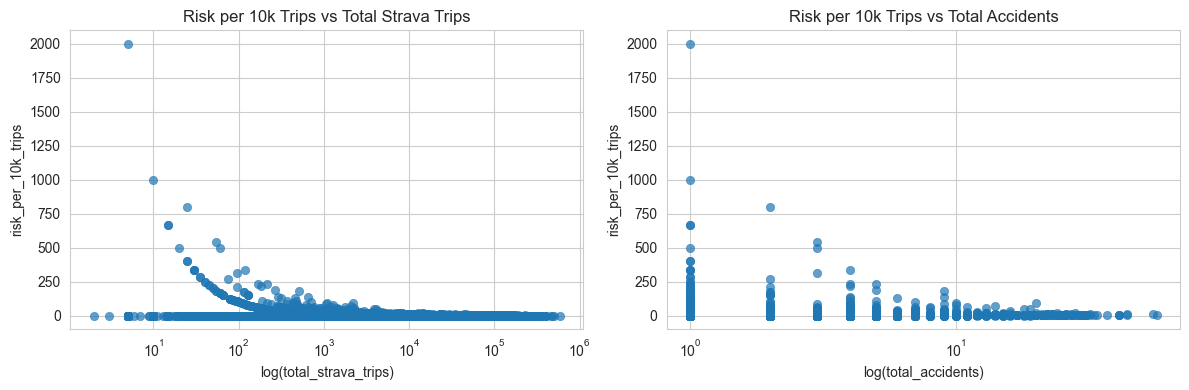

In [54]:
# Outlier visualization based on aggregated data
# Always use a fresh copy for analysis
outlier_df = combined_panel_seasonal_flat.copy()

# Calculate risk per 10k trips if not present
if 'risk_per_10k_trips' not in outlier_df.columns:
    outlier_df['risk_per_10k_trips'] = outlier_df['total_accidents'] / outlier_df['total_strava_trips'].replace({0: np.nan}) * 1e4

import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Scatterplot 1: risk_per_10k_trips vs total_strava_trips
sns.scatterplot(
    x=outlier_df['total_strava_trips'],
    y=outlier_df['risk_per_10k_trips'],
    ax=axs[0],
    alpha=0.7,
    edgecolor=None
)
axs[0].set_xlabel('log(total_strava_trips)')
axs[0].set_ylabel('risk_per_10k_trips')
axs[0].set_title('Risk per 10k Trips vs Total Strava Trips')
axs[0].set_xscale('log')

# Scatterplot 2: risk_per_10k_trips vs total_accidents
sns.scatterplot(
    x=outlier_df['total_accidents'],
    y=outlier_df['risk_per_10k_trips'],
    ax=axs[1],
    alpha=0.7,
    edgecolor=None
)
axs[1].set_xlabel('log(total_accidents)')
axs[1].set_ylabel('risk_per_10k_trips')
axs[1].set_title('Risk per 10k Trips vs Total Accidents')
axs[1].set_xscale('log')

plt.tight_layout()
plt.show()

/var/folders/v0/vr_3rk6x4_5816c2kvvz854w0000gn/T/ipykernel_10728/4114218277.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = risk_stats_df.groupby('trips_bin')['risk_per_10k_trips'].agg(['mean', 'std', 'count']).reset_index()


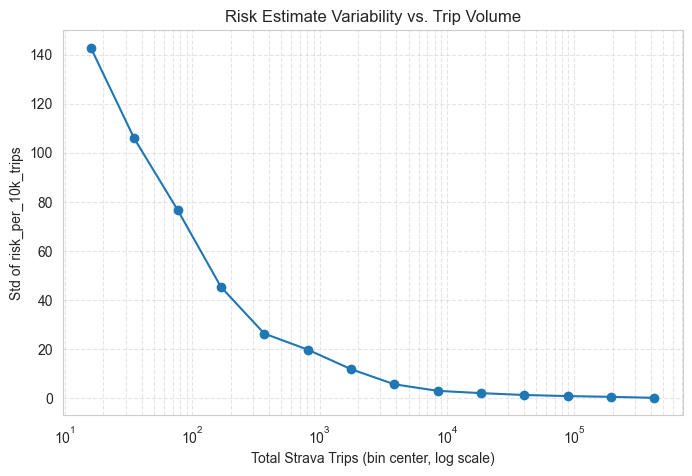

,trips_bin,count,mean,std
0,"(9.999, 21.907]",102,27.777778,142.821123
1,"(21.907, 47.993]",140,29.399093,105.917069
2,"(47.993, 105.141]",188,27.386791,76.794528
3,"(105.141, 230.337]",243,17.710811,45.388193
4,"(230.337, 504.608]",312,12.315330,26.353857
5,"(504.608, 1105.465]",339,9.880936,19.829261
6,"(1105.465, 2421.787]",525,6.623587,11.859157
7,"(2421.787, 5305.505]",783,3.583688,5.691762
8,"(5305.505, 11622.981]",1149,2.152559,3.023464
9,"(11622.981, 25462.93]",1423,1.549834,2.085233


In [56]:
# Additional analysis: How many trips are needed for stable risk estimates?
# Use the already prepared outlier_df
risk_stats_df = outlier_df.copy()

import numpy as np
import matplotlib.pyplot as plt

# Remove zero or negative values
risk_stats_df = risk_stats_df[risk_stats_df['total_strava_trips'] >= 10].copy()

# Bin by total_strava_trips (log bins)
bins = np.logspace(np.log10(risk_stats_df['total_strava_trips'].min()), np.log10(risk_stats_df['total_strava_trips'].max()), 15)
bins = np.unique(bins)
if len(bins) < 2:
    raise ValueError("Not enough unique bins for binning. Check your data range.")
risk_stats_df['trips_bin'] = pd.cut(risk_stats_df['total_strava_trips'], bins, include_lowest=True)

# For each bin, calculate mean and std of risk
bin_stats = risk_stats_df.groupby('trips_bin')['risk_per_10k_trips'].agg(['mean', 'std', 'count']).reset_index()

# Plot std of risk vs. bin center
bin_centers = [interval.mid for interval in bin_stats['trips_bin']]
plt.figure(figsize=(8,5))
plt.plot(bin_centers, bin_stats['std'], marker='o')
plt.xscale('log')
plt.xlabel('Total Strava Trips (bin center, log scale)')
plt.ylabel('Std of risk_per_10k_trips')
plt.title('Risk Estimate Variability vs. Trip Volume')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.show()

# Show table for reference
bin_stats[['trips_bin', 'count', 'mean', 'std']]

**Summary and Outlier Interpretation (with exact values):**

- Segments with very few trips or accidents often show high risk values, but these are usually statistical artifacts, not true danger.
- As trip or accident counts increase, risk estimates become more stable and reliable.
- Outliers with high risk and low data should be treated with caution—they rarely indicate real risk.

**How many trips are enough for stable risk estimates?**

- Std of risk is very high (40–80) for <500 trips.
- Std drops to ~24 at 700–1300 trips.
- Std <10 for 2300+ trips, and ~5 for 4000+ trips.

**Conclusion:**
Reliable risk estimates require at least 1000–2000 trips per segment. Below this, risk values are unstable.

# Feature Importance Analysis

This section evaluates the importance of accident category shares for risk using Spearman correlation (With risk_per_10k_trips)

Segments before trip filter: 7763, after (['total_strava_trips'] >= 200): 6428, lost: 1335 (17.2%)
=== Spearman correlation of *_share_* features with risk (risk_per_10k_trips) ===


,feature,spearman_rho,p_value
5,acc_time_of_day_share_evening (18h-22h),0.137030,3.207247e-19
1,acc_light_condition_share_1.0,0.133544,2.518268e-18
2,acc_light_condition_share_2.0,0.117744,1.465149e-14
6,acc_time_of_day_share_night (22h-7h),0.111529,3.290055e-13
4,acc_weekday_type_share_weekend,0.106600,3.445678e-12
3,acc_weekday_type_share_weekday,-0.106600,3.445678e-12
0,acc_light_condition_share_0.0,-0.101048,4.283477e-11
7,acc_time_of_day_share_work_hours (7h-18h),-0.093049,1.282649e-09


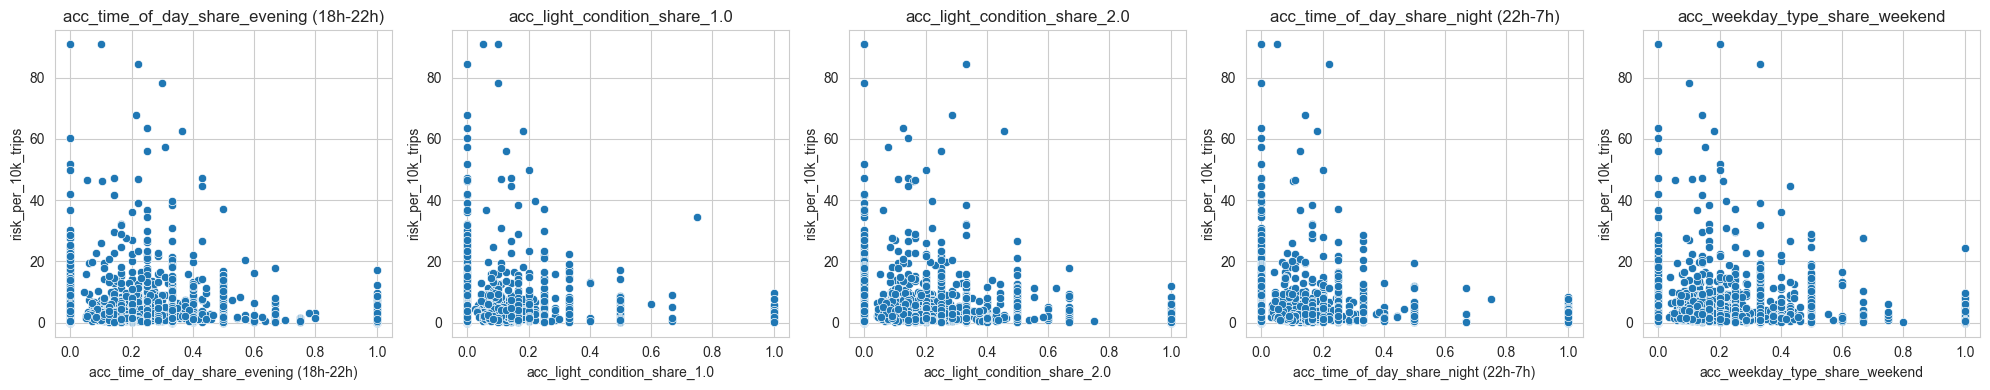

In [58]:
# Calculate risk and feature shares, filter segments
analysis_df = combined_panel_seasonal_flat.copy()

# Filter segments with low traffic
n_before_trips = len(analysis_df)
analysis_df = analysis_df[analysis_df['total_strava_trips'] >= 1000].copy()
n_after_trips = len(analysis_df)
print(f"Segments before trip filter: {n_before_trips}, after (['total_strava_trips'] >= 200): {n_after_trips}, lost: {n_before_trips - n_after_trips} ({100*(n_before_trips-n_after_trips)/n_before_trips:.1f}%)")

# Filter segments with low accident count
# n_before_acc = len(analysis_df)
# # analysis_df = analysis_df[analysis_df['total_accidents'] >= 5].copy()
# n_after_acc = len(analysis_df)
# print(f"Segments before accident filter: {n_before_acc}, after (['total_accidents'] >= 5): {n_after_acc}, lost: {n_before_acc - n_after_acc} ({100*(n_before_acc-n_after_acc)/n_before_acc:.1f}%)")

# Calculate risk per 10k trips
analysis_df['risk_per_10k_trips'] = analysis_df['total_accidents'] / analysis_df['total_strava_trips'].replace({0: np.nan}) * 1e4

# Calculate share for all *_count_* columns as share of total_accidents
count_cols = [c for c in analysis_df.columns if '_count_' in c]
for col in count_cols:
    share_col = col.replace('_count_', '_share_')
    analysis_df[share_col] = analysis_df[col] / analysis_df['total_accidents'].replace({0: np.nan})

# Use only *_share_* columns for correlation analysis
share_cols = [c for c in analysis_df.columns if '_share_' in c]

corrs = []
for col in share_cols:
    rho, pval = scipy.stats.spearmanr(analysis_df[col], analysis_df['risk_per_10k_trips'], nan_policy='omit')
    corrs.append({'feature': col, 'spearman_rho': rho, 'p_value': pval})
corrs_df = pd.DataFrame(corrs).sort_values('spearman_rho', key=abs, ascending=False)

print('=== Spearman correlation of *_share_* features with risk (risk_per_10k_trips) ===')
display(corrs_df)

# Visualize top-5 features
# Scatterplots for the top-5 features with highest absolute correlation
# Each plot shows the relationship between the feature and risk
top5 = corrs_df.head(5)['feature']
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, col in enumerate(top5):
    sns.scatterplot(x=analysis_df[col], y=analysis_df['risk_per_10k_trips'], ax=axs[i])
    axs[i].set_title(col)
plt.tight_layout()
plt.show()


### Statistical Interpretation of Accidents Feature Importance Analysis

**Light condition codes:** 0 = daylight, 1 = twilight, 2 = darkness.

- All feature-risk correlations are statistically significant but weak (|ρ| < 0.15).
- Segments with a higher share of evening, night, darkness, or weekend accidents have slightly higher risk, but the effect is small.
- Negative correlations for weekday and daylight shares: more accidents in these categories → slightly lower risk.

**Why are correlations so weak?**
This is mainly because most segments have very few accidents (see the left plot above: most points are at low accident counts). With so little data per segment, risk estimates are highly variable and noisy, making it hard to detect strong relationships between features and risk.

**Conclusion:**
No single accident feature share is a strong predictor of segment risk. Temporal and light condition features explain only a small part of risk variation.

# Descriptive Statistics for Categorical Features

This section provides descriptive statistics for each categorical feature in the segment panel. 
All connectivity and infrastructure columns are constant over time per segment, so we can use them directly in aggregated by segment data.

Our dataset for analysis aggregated by segment (no year/month columns is used, for reasoned descibed above)

In [72]:
# Prepare segment_panel for categorical feature analysis
# Keep only selected categorical features and aggregate metrics over all years/months

cat_features = [
    'infrastructure_bicyclelane_type',
    'infrastructure_type_of_street',
    'infrastructure_number_of_street_lanes',
    'infrastructure_street_surface',
    'infrastructure_max_speed',
    'infrastructure_is_within_cyclingroute',
    'connectivity_is_cycling_main_network',
    'connectivity_is_cycling_minor_network',
]

# Columns to keep: id, all cat_features, metrics to sum
cols_to_keep = ['counter_name'] + cat_features + ['monthly_strava_trips', 'total_accidents']
segment_panel_cat = segment_panel[cols_to_keep].copy()

# Aggregate by all categorical features (they are constant per segment), summing metrics
segment_panel_cat_agg = segment_panel_cat.groupby(['counter_name'] + cat_features, as_index=False)[['monthly_strava_trips', 'total_accidents']].sum()

# Add risk column (accidents per 10k trips)
segment_panel_cat_agg['risk_per_10k_trips'] = segment_panel_cat_agg['total_accidents'] / segment_panel_cat_agg['monthly_strava_trips'].replace({0: np.nan}) * 1e4
segment_panel_cat_agg = segment_panel_cat_agg[segment_panel_cat_agg.monthly_strava_trips > 1000]

# Display the result
display(segment_panel_cat_agg.head())
segment_panel_cat_agg.describe()

,counter_name,infrastructure_bicyclelane_type,infrastructure_type_of_street,infrastructure_number_of_street_lanes,infrastructure_street_surface,infrastructure_max_speed,infrastructure_is_within_cyclingroute,connectivity_is_cycling_main_network,connectivity_is_cycling_minor_network,monthly_strava_trips,total_accidents,risk_per_10k_trips
0,streetsegment_0,no bicycle lane,residential,infrastructure_number_of_street_lanes_isnan,asphalt,speed_is_30.0,False,False,True,21560.0,16.0,7.421150
2,streetsegment_10,bicycle lane on sidewalk,secondary,infrastructure_number_of_street_lanes_is6.0,asphalt,speed_is_50.0,False,False,True,68495.0,6.0,0.875976
3,streetsegment_100,no bicycle lane,secondary,infrastructure_number_of_street_lanes_is2.0,asphalt,speed_is_50.0,True,True,False,65505.0,0.0,0.000000
4,streetsegment_1000,no bicycle lane,residential,infrastructure_number_of_street_lanes_isnan,sett,speed_is_20.0,False,True,False,1890.0,0.0,0.000000
6,streetsegment_1002,bicycle lane on sidewalk,residential,infrastructure_number_of_street_lanes_isnan,asphalt,speed_is_30.0,False,True,False,71680.0,0.0,0.000000


,monthly_strava_trips,total_accidents,risk_per_10k_trips
count,3810.000000,3810.000000,3810.000000
mean,32989.335958,3.723622,2.894235
std,45328.296839,5.168161,6.150084
min,1005.000000,0.000000,0.000000
25%,6310.000000,0.000000,0.000000
50%,17975.000000,2.000000,1.020963
75%,42045.000000,5.000000,3.026190
max,586505.000000,57.000000,90.909091


In [75]:
# Convert 'infrastructure_max_speed' categories to integer values (strict: only 0, 10, 20, 30, 40, 50, 60, 70, NaN)
def parse_speed(val):
    if pd.isna(val) or 'nan' in str(val):
        return np.nan
    for s in [0, 10, 20, 30, 40, 50, 60, 70]:
        if str(val) == f'speed_is_{s}.0':
            return s
    return np.nan

segment_panel_cat_agg['infrastructure_max_speed_int'] = segment_panel_cat_agg['infrastructure_max_speed'].apply(parse_speed)

print(segment_panel_cat_agg[['infrastructure_max_speed', 'infrastructure_max_speed_int']].drop_duplicates().sort_values('infrastructure_max_speed_int'))

     infrastructure_max_speed  infrastructure_max_speed_int
14               speed_is_0.0                           0.0
1464            speed_is_10.0                          10.0
4               speed_is_20.0                          20.0
0               speed_is_30.0                          30.0
2127            speed_is_40.0                          40.0
2               speed_is_50.0                          50.0
39              speed_is_60.0                          60.0
3945            speed_is_70.0                          70.0
28               speed_is_nan                           NaN


In [93]:
# Descriptive statistics for all main categorical features
cat_features = [
    'infrastructure_bicyclelane_type',
    'infrastructure_type_of_street',
    'infrastructure_number_of_street_lanes',
    'infrastructure_street_surface',
    'infrastructure_max_speed',
    'infrastructure_max_speed_int',
    'infrastructure_is_within_cyclingroute',
    'connectivity_is_cycling_main_network',
    'connectivity_is_cycling_minor_network',
]

for col in cat_features:
    print(f'\n=== {col} ===')
    print(f'Unique categories: {segment_panel_cat_agg[col].nunique()}')
    print(segment_panel_cat_agg[col].value_counts())
    stats = segment_panel_cat_agg.groupby(col).agg(
        mean_risk_per_10k_trips=('risk_per_10k_trips', 'mean'),
        mean_accidents=('total_accidents', 'mean'),
        median_accidents=('total_accidents', 'median'),
        count=('risk_per_10k_trips', 'count')
    )
    display(stats.sort_values('mean_risk_per_10k_trips', ascending=False))


=== infrastructure_bicyclelane_type ===
Unique categories: 3
infrastructure_bicyclelane_type
no bicycle lane             2450
bicycle lane on sidewalk    1085
bicycle lane on street       275
Name: count, dtype: int64


,mean_risk_per_10k_trips,mean_accidents,median_accidents,count
infrastructure_bicyclelane_type,,,,
no bicycle lane,3.403127,3.238367,2.0,2450
bicycle lane on sidewalk,2.090314,4.337327,3.0,1085
bicycle lane on street,1.532311,5.625455,4.0,275



=== infrastructure_type_of_street ===
Unique categories: 9
infrastructure_type_of_street
residential     1126
secondary        987
tertiary         600
footway          490
primary          330
unclassified     108
path             106
track             37
pedestrian        26
Name: count, dtype: int64


,mean_risk_per_10k_trips,mean_accidents,median_accidents,count
infrastructure_type_of_street,,,,
residential,4.772447,3.318828,2.0,1126
tertiary,3.035870,3.998333,2.0,600
unclassified,2.876299,1.703704,1.0,108
footway,2.660530,2.585714,1.0,490
pedestrian,1.743215,0.730769,0.0,26
secondary,1.667585,4.717325,3.0,987
path,1.384612,1.377358,0.0,106
primary,1.081203,5.333333,3.0,330
track,0.611996,0.513514,0.0,37



=== infrastructure_number_of_street_lanes ===
Unique categories: 12
infrastructure_number_of_street_lanes
infrastructure_number_of_street_lanes_isnan     1821
infrastructure_number_of_street_lanes_is2.0      957
infrastructure_number_of_street_lanes_is4.0      563
infrastructure_number_of_street_lanes_is6.0      209
infrastructure_number_of_street_lanes_is1.0      108
infrastructure_number_of_street_lanes_is3.0       56
infrastructure_number_of_street_lanes_is8.0       36
infrastructure_number_of_street_lanes_is0.0       26
infrastructure_number_of_street_lanes_is5.0       15
infrastructure_number_of_street_lanes_is10.0      14
infrastructure_number_of_street_lanes_is12.0       3
infrastructure_number_of_street_lanes_is7.0        2
Name: count, dtype: int64


,mean_risk_per_10k_trips,mean_accidents,median_accidents,count
infrastructure_number_of_street_lanes,,,,
infrastructure_number_of_street_lanes_isnan,3.701090,2.794069,1.0,1821
infrastructure_number_of_street_lanes_is1.0,3.020002,4.083333,2.5,108
infrastructure_number_of_street_lanes_is2.0,2.818534,4.443051,2.0,957
infrastructure_number_of_street_lanes_is0.0,1.743215,0.730769,0.0,26
infrastructure_number_of_street_lanes_is3.0,1.468309,4.089286,2.0,56
infrastructure_number_of_street_lanes_is4.0,1.415583,5.003552,3.0,563
infrastructure_number_of_street_lanes_is6.0,1.391963,5.200957,3.0,209
infrastructure_number_of_street_lanes_is8.0,0.868131,3.555556,2.0,36
infrastructure_number_of_street_lanes_is5.0,0.618442,5.600000,3.0,15



=== infrastructure_street_surface ===
Unique categories: 20
infrastructure_street_surface
asphalt                  3024
paving_stones             274
sett                      169
concrete                  126
unclassified               80
compacted                  47
fine_gravel                23
dirt                       14
cobblestone                10
ground                     10
concrete:plates             9
wood                        4
gravel                      4
cobblestone:flattened       4
paved                       3
grass                       3
sand                        3
pebblestone                 1
unhewn_cobblestone          1
earth                       1
Name: count, dtype: int64


,mean_risk_per_10k_trips,mean_accidents,median_accidents,count
infrastructure_street_surface,,,,
sett,5.338041,2.857988,1.0,169
concrete:plates,4.114671,3.111111,0.0,9
paving_stones,3.581962,3.160584,2.0,274
dirt,3.576407,2.285714,1.5,14
asphalt,2.779920,4.063492,2.0,3024
sand,2.663312,3.000000,2.0,3
concrete,2.625098,1.976190,1.0,126
ground,2.230148,3.200000,2.0,10
unclassified,2.002427,1.462500,1.0,80



=== infrastructure_max_speed ===
Unique categories: 9
infrastructure_max_speed
speed_is_50.0    1723
speed_is_30.0    1337
speed_is_0.0      658
speed_is_nan       43
speed_is_60.0      30
speed_is_20.0      10
speed_is_10.0       4
speed_is_70.0       4
speed_is_40.0       1
Name: count, dtype: int64


,mean_risk_per_10k_trips,mean_accidents,median_accidents,count
infrastructure_max_speed,,,,
speed_is_30.0,4.332729,3.703067,2.0,1337
speed_is_20.0,3.441834,2.500000,2.0,10
speed_is_60.0,2.436347,3.466667,2.0,30
speed_is_0.0,2.305109,2.203647,1.0,658
speed_is_50.0,2.048422,4.415554,3.0,1723
speed_is_nan,1.837672,0.953488,0.0,43
speed_is_40.0,0.215790,4.000000,4.0,1
speed_is_10.0,0.160051,0.250000,0.0,4
speed_is_70.0,0.150096,0.750000,0.5,4



=== infrastructure_max_speed_int ===
Unique categories: 8
infrastructure_max_speed_int
50.0    1723
30.0    1337
0.0      658
60.0      30
20.0      10
10.0       4
70.0       4
40.0       1
Name: count, dtype: int64


,mean_risk_per_10k_trips,mean_accidents,median_accidents,count
infrastructure_max_speed_int,,,,
30.0,4.332729,3.703067,2.0,1337
20.0,3.441834,2.500000,2.0,10
60.0,2.436347,3.466667,2.0,30
0.0,2.305109,2.203647,1.0,658
50.0,2.048422,4.415554,3.0,1723
40.0,0.215790,4.000000,4.0,1
10.0,0.160051,0.250000,0.0,4
70.0,0.150096,0.750000,0.5,4



=== infrastructure_is_within_cyclingroute ===
Unique categories: 2
infrastructure_is_within_cyclingroute
False    3227
True      583
Name: count, dtype: int64


,mean_risk_per_10k_trips,mean_accidents,median_accidents,count
infrastructure_is_within_cyclingroute,,,,
False,3.207919,3.660985,2.0,3227
True,1.157944,4.070326,2.0,583



=== connectivity_is_cycling_main_network ===
Unique categories: 2
connectivity_is_cycling_main_network
False    2057
True     1753
Name: count, dtype: int64


,mean_risk_per_10k_trips,mean_accidents,median_accidents,count
connectivity_is_cycling_main_network,,,,
False,3.176890,3.438503,2.0,2057
True,2.562564,4.058186,2.0,1753



=== connectivity_is_cycling_minor_network ===
Unique categories: 2
connectivity_is_cycling_minor_network
True     2057
False    1753
Name: count, dtype: int64


,mean_risk_per_10k_trips,mean_accidents,median_accidents,count
connectivity_is_cycling_minor_network,,,,
True,3.176890,3.438503,2.0,2057
False,2.562564,4.058186,2.0,1753


### Category grouping for robust regression
We group rare and similar categories into broader, interpretable groups for key infrastructure features. This improves model stability and interpretability.

In [95]:
# Grouping infrastructure_type_of_street into broader categories
def group_street_type(val):
    if val in ['primary', 'secondary', 'tertiary']:
        return 'main_road'
    elif val in ['residential', 'unclassified']:
        return 'residential'
    elif val in ['path', 'track', 'footway', 'pedestrian']:
        return 'path'
    else:
        return 'other'
segment_panel_cat_agg['street_type_grouped'] = segment_panel_cat_agg['infrastructure_type_of_street'].apply(group_street_type)

# Grouping infrastructure_number_of_street_lanes
def group_lanes(val):
    if 'isnan' in str(val):
        return 'unknown'
    elif val in ['infrastructure_number_of_street_lanes_is1.0', 'infrastructure_number_of_street_lanes_is2.0']:
        return '1-2'
    elif val in ['infrastructure_number_of_street_lanes_is3.0', 'infrastructure_number_of_street_lanes_is4.0']:
        return '3-4'
    else:
        return '5+'
segment_panel_cat_agg['lanes_grouped'] = segment_panel_cat_agg['infrastructure_number_of_street_lanes'].apply(group_lanes)

# Grouping infrastructure_street_surface
def group_surface(val):
    if val in ['asphalt', 'concrete', 'concrete:plates', 'paved']:
        return 'asphalt'
    elif val in ['paving_stones', 'sett', 'cobblestone', 'cobblestone:flattened', 'unhewn_cobblestone', 'pebblestone']:
        return 'stones'
    else:
        return 'loose'
segment_panel_cat_agg['surface_grouped'] = segment_panel_cat_agg['infrastructure_street_surface'].apply(group_surface)

# Grouping infrastructure_max_speed
def group_speed(val):
    if val == 'speed_is_0.0':
        return '0'
    elif val in ['speed_is_10.0', 'speed_is_20.0', 'speed_is_30.0']:
        return '<=30'
    elif val in ['speed_is_40.0', 'speed_is_50.0']:
        return '40-50'
    elif val in ['speed_is_60.0', 'speed_is_70.0']:
        return '60+'
    else:
        return 'unknown'
segment_panel_cat_agg['speed_grouped'] = segment_panel_cat_agg['infrastructure_max_speed'].apply(group_speed)

# Show new grouped columns
display(segment_panel_cat_agg[['infrastructure_type_of_street', 'street_type_grouped']].drop_duplicates().sort_values('street_type_grouped'))
display(segment_panel_cat_agg[['infrastructure_number_of_street_lanes', 'lanes_grouped']].drop_duplicates().sort_values('lanes_grouped'))
display(segment_panel_cat_agg[['infrastructure_street_surface', 'surface_grouped']].drop_duplicates().sort_values('surface_grouped'))
display(segment_panel_cat_agg[['infrastructure_max_speed', 'speed_grouped']].drop_duplicates().sort_values('speed_grouped'))

,infrastructure_type_of_street,street_type_grouped
2,secondary,main_road
36,tertiary,main_road
39,primary,main_road
14,footway,path
111,track,path
201,path,path
343,pedestrian,path
0,residential,residential
12,unclassified,residential


,infrastructure_number_of_street_lanes,lanes_grouped
3,infrastructure_number_of_street_lanes_is2.0,1-2
51,infrastructure_number_of_street_lanes_is1.0,1-2
9,infrastructure_number_of_street_lanes_is4.0,3-4
98,infrastructure_number_of_street_lanes_is3.0,3-4
2,infrastructure_number_of_street_lanes_is6.0,5+
103,infrastructure_number_of_street_lanes_is5.0,5+
184,infrastructure_number_of_street_lanes_is8.0,5+
206,infrastructure_number_of_street_lanes_is12.0,5+
338,infrastructure_number_of_street_lanes_is7.0,5+
343,infrastructure_number_of_street_lanes_is0.0,5+


,infrastructure_street_surface,surface_grouped
0,asphalt,asphalt
31,concrete,asphalt
146,concrete:plates,asphalt
407,paved,asphalt
2610,sand,loose
1715,gravel,loose
423,grass,loose
410,ground,loose
395,wood,loose
353,fine_gravel,loose


,infrastructure_max_speed,speed_grouped
14,speed_is_0.0,0
2,speed_is_50.0,40-50
2127,speed_is_40.0,40-50
39,speed_is_60.0,60+
3945,speed_is_70.0,60+
0,speed_is_30.0,<=30
4,speed_is_20.0,<=30
1464,speed_is_10.0,<=30
28,speed_is_nan,unknown


## Regression Analysis

In [86]:
# Poisson regression: effect of categorical features on accident count (with exposure)
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Filter: only segments with at least 100 monthly_strava_trips and >0 trips
poisson_df = segment_panel_cat_agg[[
    'total_accidents',
    'monthly_strava_trips',
    'infrastructure_bicyclelane_type',
    'infrastructure_type_of_street',
    'infrastructure_number_of_street_lanes',
    'infrastructure_street_surface',
    'infrastructure_max_speed_int',
    'infrastructure_is_within_cyclingroute',
    'connectivity_is_cycling_main_network',
    'connectivity_is_cycling_minor_network'
]].dropna()

poisson_formula = (
    'total_accidents ~ '
    'C(infrastructure_bicyclelane_type) + '
    'C(infrastructure_type_of_street) + '
    'C(infrastructure_number_of_street_lanes) + '
    'C(infrastructure_street_surface) + '
    'infrastructure_max_speed_int + '
    'C(infrastructure_is_within_cyclingroute) + '
    'C(connectivity_is_cycling_main_network) + '
    'C(connectivity_is_cycling_minor_network)'
)

poisson_model = smf.glm(
    formula=poisson_formula,
    data=poisson_df,
    family=sm.families.Poisson(),
    offset=np.log(poisson_df['monthly_strava_trips'])
).fit()

print(poisson_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        total_accidents   No. Observations:                 3767
Model:                            GLM   Df Residuals:                     3724
Model Family:                 Poisson   Df Model:                           42
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14623.
Date:                Mon, 19 Jan 2026   Deviance:                       20603.
Time:                        13:08:16   Pearson chi2:                 3.56e+04
No. Iterations:                    23   Pseudo R-squ. (CS):             0.6928
Covariance Type:            nonrobust                                         
                                                                                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------

### Overdispersion Check for Poisson Regression

В контексте Poisson GLM для счётных данных (например, total_accidents) модель предполагает, что среднее и дисперсия равны. Но в реальных данных часто дисперсия больше среднего — это и есть overdispersion.


To check if the Poisson model is appropriate, we calculate the overdispersion statistic (Pearson chi² / degrees of freedom). If this value is much greater than 1, the data are overdispersed and Negative Binomial regression is preferred.

In [87]:
# Calculate overdispersion for Poisson GLM
pearson_chi2 = poisson_model.pearson_chi2
df_resid = poisson_model.df_resid
overdispersion = pearson_chi2 / df_resid
print(f'Overdispersion statistic (Pearson chi² / df): {overdispersion:.2f}')
if overdispersion > 1.5:
    print('Warning: Overdispersion detected. Consider using Negative Binomial regression.')
else:
    print('No strong overdispersion detected. Poisson model may be appropriate.')

Overdispersion statistic (Pearson chi² / df): 9.56


### Why Negative Binomial Regression?

Negative Binomial regression is well-suited for our data because accident counts have many zeros (zero-inflation), and there is strong heterogeneity in exposure: some segments have very low traffic, others very high. This leads to overdispersion and excess zeros, which the Negative Binomial model can handle much better than Poisson regression.

Reference categories were selected based on both empirical prevalence and substantive interpretability. For each categorical variable, the reference level corresponds to the most common and conceptually neutral category, representing a typical urban cycling environment. 

This choice ensures stable parameter estimation and allows coefficients to be interpreted as relative risk changes compared to a meaningful baseline (e.g., residential streets, asphalt surface, absence of bicycle infrastructure). As a result, estimated incidence rate ratios reflect deviations from standard cycling conditions rather than comparisons to rare or extreme cases.

In [100]:
# Negative Binomial regression using grouped categories with explicit reference categories
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Prepare data with grouped categories (drop NA)
grouped_df = segment_panel_cat_agg[[
    'total_accidents',
    'monthly_strava_trips',
    'street_type_grouped',
    'lanes_grouped',
    'surface_grouped',
    'speed_grouped',
    'infrastructure_bicyclelane_type',
    'infrastructure_is_within_cyclingroute',
    'connectivity_is_cycling_main_network',
    'connectivity_is_cycling_minor_network'
    ]].dropna()

# Set reference categories for each grouped variable
grouped_df['street_type_grouped'] = pd.Categorical(grouped_df['street_type_grouped'], categories=['residential','main_road','path','other'], ordered=False)
grouped_df['lanes_grouped'] = pd.Categorical(grouped_df['lanes_grouped'], categories=['1-2','3-4','5+','unknown'], ordered=False)
grouped_df['surface_grouped'] = pd.Categorical(grouped_df['surface_grouped'], categories=['asphalt','stones','loose'], ordered=False)
grouped_df['speed_grouped'] = pd.Categorical(grouped_df['speed_grouped'], categories=['<=30','40-50','60+','0','unknown'], ordered=False)

# Model formula with grouped categories
nb_formula_grouped = (
    'total_accidents ~ '
    'C(street_type_grouped, Treatment(reference="residential")) + '
    'C(lanes_grouped, Treatment(reference="1-2")) + '
    'C(surface_grouped, Treatment(reference="asphalt")) + '
    'C(speed_grouped, Treatment(reference="<=30")) + '
    'C(infrastructure_bicyclelane_type) + '
    'C(infrastructure_is_within_cyclingroute) + '
    'C(connectivity_is_cycling_main_network) + '
    'C(connectivity_is_cycling_minor_network)'
)

# Fit Negative Binomial GLM
nb_model_grouped = smf.glm(
    formula=nb_formula_grouped,
    data=grouped_df,
    family=sm.families.NegativeBinomial(),
    offset=np.log(grouped_df['monthly_strava_trips'])
).fit()

print(nb_model_grouped.summary())

# Overdispersion check for NB model
pearson_chi2_nb = nb_model_grouped.pearson_chi2
df_resid_nb = nb_model_grouped.df_resid
overdispersion_nb = pearson_chi2_nb / df_resid_nb
print(f'Overdispersion statistic (Pearson chi² / df): {overdispersion_nb:.2f}')
if overdispersion_nb > 1.5:
    print('Warning: Overdispersion detected. NB model is justified.')
else:
    print('No strong overdispersion detected. NB model may be conservative.')

# IRR and 95% CI
grouped_irr = np.exp(nb_model_grouped.params)
grouped_ci = np.exp(nb_model_grouped.conf_int())
grouped_ci.columns = ['IRR_2.5%', 'IRR_97.5%']
grouped_results_table = (
    pd.concat([grouped_irr, grouped_ci], axis=1)
    .rename(columns={0: 'IRR'})
    .sort_values('IRR', ascending=False)
    )
print("\nIncidence Rate Ratios (IRR) with 95% CI (grouped categories):")
display(grouped_results_table)

/Users/laysan/Desktop/University/data_literacy_/data_literacy/venv/lib/python3.14/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:        total_accidents   No. Observations:                 3810
Model:                            GLM   Df Residuals:                     3794
Model Family:        NegativeBinomial   Df Model:                           15
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9335.7
Date:                Mon, 19 Jan 2026   Deviance:                       5380.9
Time:                        13:51:32   Pearson chi2:                 7.72e+03
No. Iterations:                    98   Pseudo R-squ. (CS):             0.2002
Covariance Type:            nonrobust                                         
                                                                              coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

,IRR,IRR_2.5%,IRR_97.5%
"C(surface_grouped, Treatment(reference=""asphalt""))[T.stones]",1.931794,1.664486,2.242031
C(infrastructure_bicyclelane_type)[T.no bicycle lane],1.045299,0.950239,1.149870
"C(lanes_grouped, Treatment(reference=""1-2""))[T.unknown]",1.032695,0.917464,1.162398
"C(surface_grouped, Treatment(reference=""asphalt""))[T.loose]",1.017549,0.786421,1.316605
"C(street_type_grouped, Treatment(reference=""residential""))[T.other]",1.000000,1.000000,1.000000
"C(street_type_grouped, Treatment(reference=""residential""))[T.path]",0.981177,0.060921,15.802636
C(infrastructure_bicyclelane_type)[T.bicycle lane on street],0.900503,0.776085,1.044867
"C(speed_grouped, Treatment(reference=""<=30""))[T.60+]",0.867914,0.570449,1.320495
"C(speed_grouped, Treatment(reference=""<=30""))[T.40-50]",0.821641,0.727032,0.928561
"C(street_type_grouped, Treatment(reference=""residential""))[T.main_road]",0.672956,0.585503,0.773471


**Interpretation framework**

All effects are interpreted as incidence rate ratios (IRR) relative to meaningful baseline conditions:

Reference categories were chosen to represent common, neutral urban cycling conditions with sufficient sample size. 

This ensures stable coefficient estimates and allows effects to be interpreted as relative risk changes from a meaningful baseline **(e.g., residential streets, asphalt surface, 1–2 lanes, low-speed streets)**. 

### Key Results: Negative Binomial Regression (total_accidents)

- **Model fit:**
    - The Negative Binomial specification is appropriate, with moderate overdispersion and stable convergence, indicating a good fit for rare accident counts with heterogeneous exposure.
    - Pseudo R² (Cragg–Uhler) = 0.20, which is high for count models of rare events with exposure offsets, indicating that infrastructure characteristics explain a substantial share of systematic risk variation.
- **Overdispersion check:** Pearson chi² / df = 1.93 (>1.5, overdispersion present, NB model justified)


| Feature group              | Variable (vs. reference)     |       IRR |         95% CI | Effect on risk | IRR interpretation       |
| -------------------------- | ---------------------------- | --------: | -------------: | -------------- | ------------------------ |
| **Cycling network**        | Main cycling network (True)  | **0.069** | [0.065, 0.073] | ↓↓↓            | ~93% lower risk per trip |
|                            | Minor cycling network (True) | **0.077** | [0.072, 0.081] | ↓↓↓            | ~92% lower risk per trip |
| **Cycling infrastructure** | Within cycling route (True)  | **0.433** | [0.390, 0.480] | ↓↓             | ~57% lower risk per trip |
| **Street type**            | Main road vs residential     | **0.673** | [0.586, 0.773] | ↓              | ~33% lower risk per trip |
| **Street geometry**        | 3–4 lanes vs 1–2             | **0.655** | [0.582, 0.737] | ↓              | ~35% lower risk per trip |
|                            | 5+ lanes vs 1–2              | **0.533** | [0.458, 0.620] | ↓↓             | ~47% lower risk per trip |
| **Surface quality**        | Stones vs asphalt            |  **1.93** |   [1.66, 2.24] | ↑↑             | ~2× higher risk per trip |
| **Speed**                  | 40–50 km/h vs ≤30            | **0.822** | [0.727, 0.929] | ↓              | ~18% lower risk per trip |
          |


**Strongest protective factor:**
Belonging to the cycling network (main or minor) → ~92–93% lower risk per trip.

**Second most important factor:**
Dedicated cycling routes → ~57% lower risk, independent of lane type.

**Street hierarchy matters:**
Main roads are safer per trip than residential streets, likely due to better structure and predictability rather than lower absolute danger.

**Surface quality is a key risk driver:**
Stone-based surfaces nearly double accident risk compared to asphalt.

**Lane count effects are structural, not causal:**
Wider roads show lower per-trip risk, likely reflecting street design and cyclist self-selection.

**What does not matter on its own:**
Bicycle lane type without network integration does not significantly change risk.